In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels as sm
from statsmodels.tsa.api import VAR

In [102]:
def inflation_expectations(data):

    model = sm.tsa.ar_model.AutoReg(endog=data.dropna(),lags=12)
    return model.fit().forecast(120).mean()

In [27]:
#usunięto ostatni rząd
df_source = pd.read_excel('ie_data.xlsx',sheet_name='Data', header=7, usecols=['Date','CAPE', 'Rate GS10', 'CPI', 'P', 'D', 'E'], parse_dates=True, index_col='Date')
df_source.index = pd.date_range(start='1871-01-01',end='2023-10-01',freq='M')
df_source.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1833 entries, 1871-01-31 to 2023-09-30
Freq: M
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   P          1833 non-null   float64
 1   D          1830 non-null   float64
 2   E          1830 non-null   float64
 3   CPI        1833 non-null   float64
 4   Rate GS10  1833 non-null   float64
 5   CAPE       1713 non-null   float64
dtypes: float64(6)
memory usage: 100.2 KB


In [104]:
df_source.tail(10)

,P,D,E,CPI,Rate GS10,CAPE
2022-12-31,3912.380952,66.920000,172.750000,296.7970,3.62,28.316901
2023-01-31,3960.656500,67.350000,173.556667,299.1700,3.53,28.334813
2023-02-28,4079.684737,67.780000,174.363333,300.8400,3.75,28.919763
2023-03-31,3968.559130,68.210000,175.170000,301.6750,3.66,27.953041
2023-04-30,4121.467368,68.376667,177.170000,303.3630,3.46,28.764684
2023-05-31,4146.173182,68.543333,179.170000,304.1270,3.57,28.761806
2023-06-30,4345.372857,68.710000,181.170000,305.1090,3.75,29.939593
2023-07-31,4508.075500,NaN,NaN,305.6910,3.90,30.890926
2023-08-31,4457.358696,NaN,NaN,305.9820,4.17,30.469743
2023-09-30,4515.770000,NaN,NaN,306.1275,4.09,30.810961


In [106]:
data = pd.DataFrame({})
data['Price'] = df_source['P']
data['cape_inv'] = 1/df_source['CAPE']
data['cpi'] = df_source['CPI'].pct_change(periods=12)
data['infl_expect'] = data['cpi'].rolling(361).apply(lambda x: inflation_expectations(x))
data['r10yb'] = df_source['Rate GS10']/100 - data['infl_expect']
data['eqvol'] = df_source['P'].pct_change().rolling(12).std()
data['bndyvol'] = df_source['Rate GS10'].rolling(12).std()
data['epsgr'] = df_source['E']/df_source['E'].shift(240)
data['por'] = df_source['D']/df_source['E']
data['D'] = 0

#var_exog = np.log(var_exog)
np.round(data.tail(10),3)

,Price,cape_inv,cpi,infl_expect,r10yb,eqvol,bndyvol,epsgr,por,D
2022-12-31,3912.381,0.035,0.065,0.024,0.012,0.043,0.734,6.261,0.387,0
2023-01-31,3960.656,0.035,0.064,0.025,0.011,0.043,0.646,6.090,0.388,0
2023-02-28,4079.685,0.035,0.060,0.025,0.013,0.044,0.553,5.929,0.389,0
2023-03-31,3968.559,0.036,0.049,0.023,0.014,0.045,0.435,5.777,0.389,0
2023-04-30,4121.467,0.035,0.049,0.024,0.010,0.047,0.387,5.584,0.386,0
2023-05-31,4146.173,0.035,0.040,0.023,0.013,0.040,0.349,5.406,0.383,0
2023-06-30,4345.373,0.033,0.030,0.022,0.015,0.040,0.337,5.244,0.379,0
2023-07-31,4508.076,0.032,0.032,0.024,0.015,0.041,0.283,NaN,NaN,0
2023-08-31,4457.359,0.033,0.033,0.024,0.018,0.038,0.216,NaN,NaN,0
2023-09-30,4515.770,0.032,0.031,0.024,0.017,0.028,0.227,NaN,NaN,0


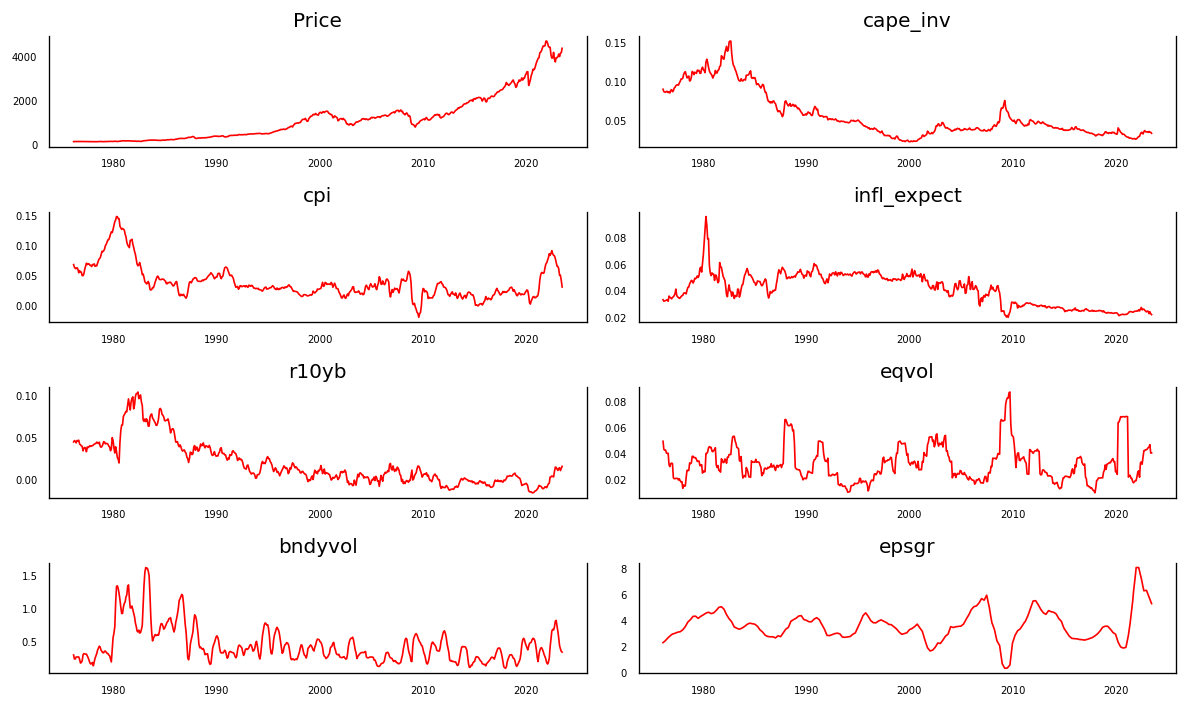

In [107]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data1 = data['1976-01-01':'2023-07-01'][data.columns[i]]
    ax.plot(data1, color='red', linewidth=1)
    # Decorations
    ax.set_title(data.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

<AxesSubplot:>

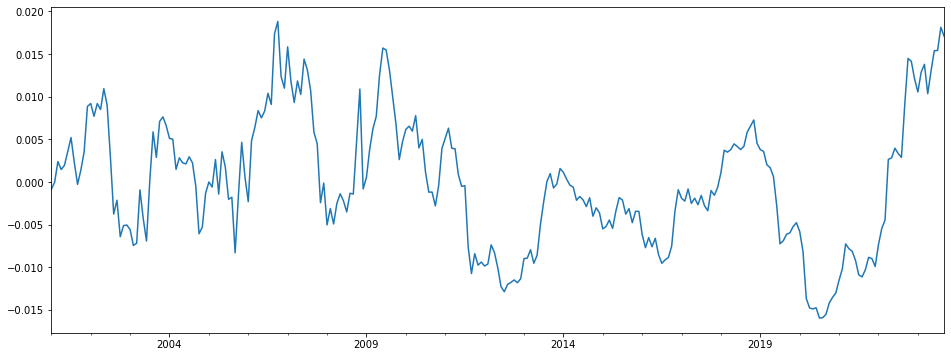

In [110]:
data['r10yb']['2001-01-01':].plot(figsize=(16,6))


var_exog: 
- cape_inv: 1/cape 
- r10yb: - Real 10-year bond yields (nominal yeld-expected inflation)
- cpi: Year-over-year CPI inflation rate
- eqvol: Realized S&P500 price volatility, over trailing 12 months,
- bndyvol: Realized volatility of changes in our real bond yield series, over trailing 12 months
'epsgr' - 10 year earnings return
por - pay-ot ratio

price - delta earngs + diwident yeld + delta valuation

In [242]:
exog_variables = ['cape_inv','r10yb','cpi','eqvol','bndyvol']
variables = data[exog_variables]
#train = np.log(data[exog_variables]['1926-01-01':'1960-12-31']+0.19)
min = variables.min()
""" variables.loc[:,'r10yb'] =  variables['r10yb'] - min['r10yb']+0.001
variables.loc[:,'cpi'] =  variables['cpi'] - min['cpi']+0.001   """
variables = np.log(variables+0.2)
train = variables['1926-01-01':'1960-01-01']
min

C:\Users\matsz\AppData\Local\Temp\ipykernel_30856\3404776927.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables.loc[:,'r10yb'] =  variables['r10yb'] - min['r10yb']+0.001
C:\Users\matsz\AppData\Local\Temp\ipykernel_30856\3404776927.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variables.loc[:,'cpi'] =  variables['cpi'] - min['cpi']+0.001


cape_inv    0.022625
r10yb      -0.024579
cpi        -0.196431
eqvol       0.009179
bndyvol     0.001549
dtype: float64

In [243]:
from statsmodels.tsa.stattools import adfuller

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")


In [354]:
for name, column in train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "cape_inv" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.4533
 No. Lags Chosen       = 9
 Critical value 1%     = -3.447
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0093. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "r10yb" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.1007
 No. Lags Chosen       = 12
 Critical value 1%     = -3.447
 Critical value 5%     = -2.869
 Critical value 10%    = -2.571
 => P-Value = 0.0265. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "cpi" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level

In [345]:
def invert_transform(forecast, add_constant):      
    return np.exp(forecast - add_constant)

In [353]:
exog_variables = ['cape_inv','r10yb','cpi','eqvol','bndyvol']
variables_raw = data[exog_variables]['1926-01-01':]
const_cor = np.array([0,0.025, 0.11, 0, 0])
variables = np.log(variables_raw+const_cor)
train = variables['1926-01-01':'1960-01-01']
#train = variables['1960-01-01':'1990-01-01']

var_model = VAR(train)
fitted = var_model.fit(12)


In [347]:
variables_raw.min()

cape_inv    0.022625
r10yb      -0.024579
cpi        -0.107383
eqvol       0.009179
bndyvol     0.003005
dtype: float64

" forecast['cpi'].plot()\ndata.loc[start_date:start_date+pd.DateOffset(months=120),'cpi'].plot() "

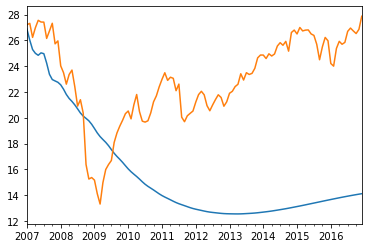

In [397]:
start_date = pd.to_datetime('2007-01-01')
start_input = start_date-pd.DateOffset(months=12)
input = variables.loc[start_input:start_date].values
forecast = fitted.forecast(input, steps=120)
forecast = invert_transform(forecast, const_cor)
forecast = pd.DataFrame(forecast, index=pd.date_range(start=start_date, freq='M', periods=120), columns=exog_variables)
cape = forecast['cape_inv'].pow(-1)
cape.plot()
test = data.loc[start_date:start_date+pd.DateOffset(months=120),'cape_inv']**-1
test.plot() 
""" forecast['cpi'].plot()
data.loc[start_date:start_date+pd.DateOffset(months=120),'cpi'].plot() """


In [390]:
(data.loc['1990-01-01':'2023-12-31','cape_inv']**-1).mean()

26.514763682409853

In [391]:
(26.5/30.8)**0.1-1

-0.014924504627331303

In [392]:
epsgr = 0.05
dy = 0.015
delta_cape = -0.013
epsgr+dy+delta_cape

0.052000000000000005